In [28]:
import pandas as pd
import nfl_data_py as nfl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from pulp import *

In [2]:
date = nfl.import_schedules([2019])
clean_date = date[['game_id', 'week', 'home_team', 'away_team' , 'home_score', 'away_score']]

In [3]:
# Erstelle Spieplan für Manager
def create_round_robin(players):
    n = len(players)
    schedule = []

    for round in range(n-1):
        for i in range(n//2):
            home = players[i]
            away = players[n - i - 1 - round]
            if i % 2 == round % 2:
                home, away = away, home
            schedule.append((round + 1, home, away))

    return schedule

def add_extra_games(schedule, players):
    n = len(players)
    rounds = len(schedule) // (n // 2)
    
    for round in range(rounds, rounds + (n - 1)//2):
        for i in range(n//2):
            home = players[i]
            away = players[n - i - 1]
            if i % 2 == round % 2:
                home, away = away, home
            schedule.append((round + 1, home, away))
    
    return schedule

managers = ['Manager_' + str(i) for i in range(1, 11)]

round_robin_schedule = create_round_robin(managers)
full_schedule = add_extra_games(round_robin_schedule, managers)

manager_schedule = pd.DataFrame(full_schedule, columns=['week', 'Manager', 'Opponent'])
manager_schedule.sort_values(by=['week', 'Manager'], inplace=True)

In [4]:
df_2020 = nfl.import_weekly_data([2020], downcast=True)
df_2020 = df_2020.loc[df_2020['season_type'] == "REG"]
df_2019 = nfl.import_weekly_data([2019], downcast=True)
df_2019 = df_2019.loc[df_2019['season_type'] == "REG"]
df_2018 = nfl.import_weekly_data([2018], downcast=True)
df_2018 = df_2018.loc[df_2018['season_type'] == "REG"]

Downcasting floats.
Downcasting floats.
Downcasting floats.


In [8]:

new_test = df_2019[['player_id', 'player_display_name', 'position_group', 'recent_team', 'season', 'week', 'completions', 'attempts','passing_yards', 'interceptions', 'passing_air_yards', 'passing_yards_after_catch', 'rushing_yards', 'fantasy_points', 'fantasy_points_ppr']]
players = new_test
games = clean_date
players['recent_team'] = players['recent_team'].replace('LV', 'OAK')
positions = ['QB', 'TE', 'WR', 'RB']
players_clean = players[players['position_group'].isin(positions)]


/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_1998/1054378363.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players['recent_team'] = players['recent_team'].replace('LV', 'OAK')


In [9]:
# Merge home games to the players DataFrame
players_home = players.merge(games, left_on=['recent_team', 'week'], right_on=['home_team', 'week'], how='left')

# Merge away games to the players DataFrame
players_away = players.merge(games, left_on=['recent_team', 'week'], right_on=['away_team', 'week'], how='left')

# Machen Sie eine explizite Kopie des DataFrame, bevor Sie Änderungen vornehmen
players_copy = players_clean.copy()

# Nun können Sie Werte sicher setzen, ohne die Warnung zu sehen
players_copy.loc[:, 'opponent'] = players_home['away_team']
players_copy.loc[:, 'opponent'] = players_copy['opponent'].fillna(players_away['home_team'])

In [11]:
# Berechnen Sie die durchschnittlichen Fantasy-Punkte, die ein Team gegen jede Position erlaubt hat
avg_fantasy_points = players_copy.groupby(['opponent', 'position_group'])['fantasy_points_ppr'].mean().reset_index()

# Nennen Sie die Spalten entsprechend um
avg_fantasy_points.columns = ['team', 'position_group', 'avg_fantasy_points_allowed']

# Zeigen Sie die Daten an
print(avg_fantasy_points)


    team position_group  avg_fantasy_points_allowed
0    ARI             QB                   12.921740
1    ARI             RB                    8.684999
2    ARI             TE                    5.513514
3    ARI             WR                    8.394828
4    ATL             QB                   16.882856
..   ...            ...                         ...
123  TEN             WR                    6.973913
124  WAS             QB                   12.860001
125  WAS             RB                   10.800000
126  WAS             TE                    6.550000
127  WAS             WR                    8.427347

[128 rows x 3 columns]


In [12]:
positions = ['QB', 'TE', 'WR', 'RB']
players_clean = players_copy[players_copy['position_group'].isin(positions)]
fantasy_clean = avg_fantasy_points[avg_fantasy_points['position_group'].isin(positions)]
players_clean = players.dropna(subset=['opponent'])


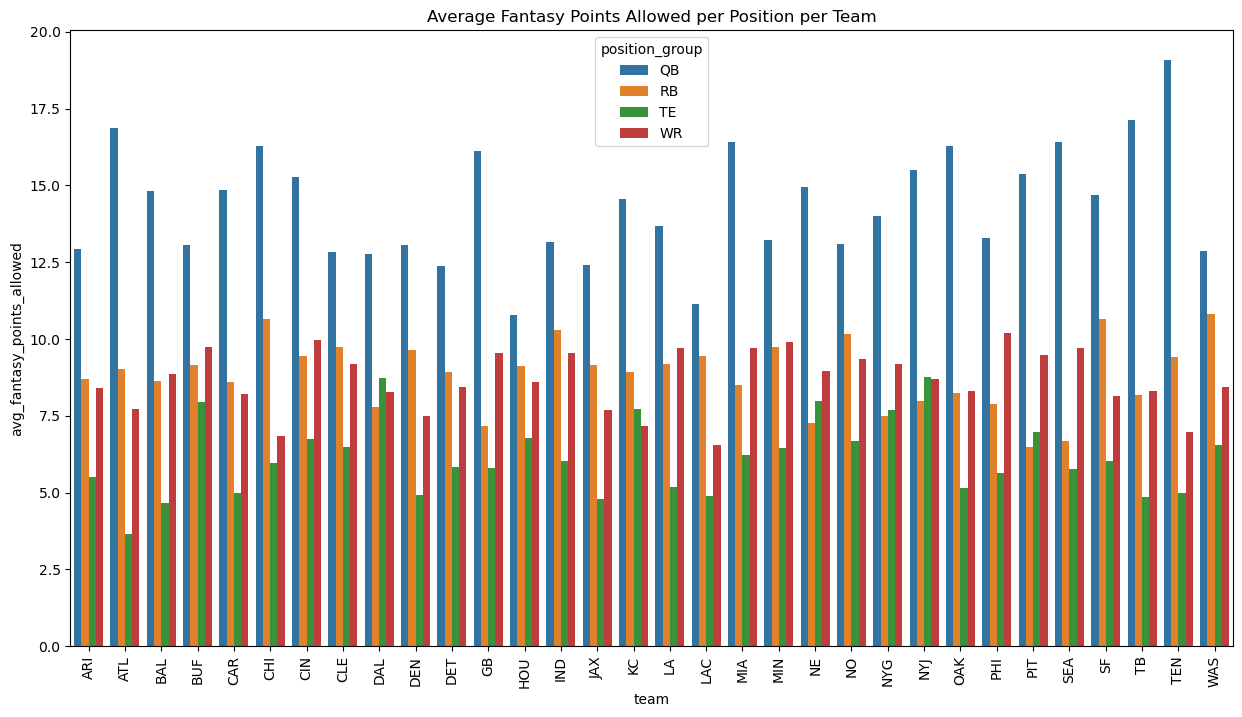

In [14]:
plt.figure(figsize=(15,8))
sns.barplot(x='team', y='avg_fantasy_points_allowed', hue='position_group', data=fantasy_clean)
plt.xticks(rotation=90)
plt.title('Average Fantasy Points Allowed per Position per Team')
plt.show()


In [16]:
# Erstelle einen DataFrame für Heimspiele
home_games = clean_date[['game_id', 'week', 'home_team']].copy()
home_games['is_home'] = True

# Erstelle einen DataFrame für Auswärtsspiele
away_games = clean_date[['game_id', 'week', 'away_team']].copy()
away_games['is_home'] = False

# Benenne die Team-Spalten um
home_games.rename(columns={'home_team': 'recent_team'}, inplace=True)
away_games.rename(columns={'away_team': 'recent_team'}, inplace=True)

# Füge die beiden DataFrames zusammen
games = pd.concat([home_games, away_games])

# Füge die `is_home` Information zu den Spielerdaten hinzu
players = players_copy.merge(games, on=['recent_team', 'week'], how='left')



In [17]:
defense_stats = avg_fantasy_points.rename(columns={'team': 'opponent'})

# Führen Sie die DataFrames zusammen
player_data = players_clean.merge(defense_stats, on=['opponent', 'position_group'], how='left')

In [19]:
# Erstelle ein DataFrame nur mit den Features, die wir verwenden wollen
features = [ 'recent_team', 'opponent', 'avg_fantasy_points_allowed', 'is_home', 'passing_air_yards', 'passing_yards_after_catch', 'rushing_yards']
X = player_data[features]
y = player_data['fantasy_points_ppr']

# Da wir kategorische Features haben, müssen wir sie in numerische Werte umwandeln
X = pd.get_dummies(X)

# Teile die Daten in Trainings- und Testdaten auf
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Erstelle das lineare Regressionsmodell
model = LinearRegression()

# Trainiere das Modell mit den Trainingsdaten
model.fit(X_train, y_train)

# Mache Vorhersagen mit den Testdaten
predictions = model.predict(X_test)

# Bewerte das Modell
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 47.29240798950195


In [20]:

# Erstelle das XGBoost Regressionsmodell
model = XGBRegressor(n_estimators=1000, learning_rate=0.05)

# Trainiere das Modell mit den Trainingsdaten
model.fit(X_train, y_train, 
          early_stopping_rounds=5, 
          eval_set=[(X_test, y_test)], 
          verbose=False)

# Mache Vorhersagen mit den Testdaten
predictions = model.predict(X_test)

# Bewerte das Modell
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

/Users/mariu/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Mean Squared Error: 44.14667510986328


In [22]:
# Erstelle ein DataFrame nur mit den Features, die wir verwenden wollen
players_features = player_data[features]

# Da wir kategorische Features haben, müssen wir sie in numerische Werte umwandeln
players_features = pd.get_dummies(players_features)

# Beachten Sie, dass wir nach dem Anwenden von get_dummies() sicherstellen müssen, dass die gleichen Spalten im 'players_features'- und 'X_train'-Dataframe vorhanden sind.
missing_cols = set(X_train.columns) - set(players_features.columns)
for c in missing_cols:
    players_features[c] = 0
players_features = players_features[X_train.columns]

# Mache Vorhersagen mit den Spielerdaten
player_predictions = model.predict(players_features)

# Füge die Vorhersagen zum 'players'-DataFrame hinzu
player_data['predicted_fantasy_points'] = player_predictions

print(player_data)

       player_id player_display_name position_group recent_team  season  week  \
0     00-0019596           Tom Brady             QB          NE    2019     1   
1     00-0019596           Tom Brady             QB          NE    2019     2   
2     00-0019596           Tom Brady             QB          NE    2019     3   
3     00-0019596           Tom Brady             QB          NE    2019     4   
4     00-0019596           Tom Brady             QB          NE    2019     5   
...          ...                 ...            ...         ...     ...   ...   
4789  00-0035624        N'Keal Harry             WR          NE    2019    12   
4790  00-0035624        N'Keal Harry             WR          NE    2019    13   
4791  00-0035624        N'Keal Harry             WR          NE    2019    14   
4792  00-0035624        N'Keal Harry             WR          NE    2019    15   
4793  00-0035624        N'Keal Harry             WR          NE    2019    16   

      completions  attempts

In [24]:
# Durchschnittliche vorhergesagte Punkte über die Saison für jeden Spieler
players_season_avg = player_data.groupby(['player_id', 'player_display_name', 'position_group'])['predicted_fantasy_points'].mean().reset_index()

# Summe der vorhergesagten Punkte über die Saison für jeden Spieler
players_season_sum = player_data.groupby(['player_id', 'player_display_name', 'position_group'])['predicted_fantasy_points'].sum().reset_index()

players_season_sum.sort_values('predicted_fantasy_points', ascending=False)

,player_id,player_display_name,position_group,predicted_fantasy_points
288,00-0033280,Christian McCaffrey,RB,407.524719
453,00-0034796,Lamar Jackson,QB,377.674774
271,00-0033077,Dak Prescott,QB,323.582703
244,00-0032764,Derrick Henry,RB,296.534058
502,00-0035228,Kyler Murray,QB,295.468903
...,...,...,...,...
2,00-0021206,Josh McCown,QB,2.678572
132,00-0031076,David Fales,QB,1.448645
206,00-0032156,Trevor Siemian,QB,1.448645
295,00-0033319,Nick Mullens,QB,1.254281


In [62]:
# Gruppieren und sortieren Sie nach 'position_group' und 'predicted_fantasy_points'
players = players_season_avg.sort_values(by=['position_group', 'predicted_fantasy_points'], ascending=[True, False])

# Berechnen Sie 'opportunity_cost' innerhalb jeder 'position_group'
players['opportunity_cost'] = players.groupby('position_group')['predicted_fantasy_points'].diff(-1).abs()

# Ersetzen Sie NaN-Werte in 'opportunity_cost' durch 0
players['opportunity_cost'].fillna(0, inplace=True)

# Berechnen Sie 'final_score' mit einer Gewichtung für 'predicted_fantasy_points' und 'opportunity_cost'
weights = {'predicted_fantasy_points': 0.7, 'opportunity_cost': 0.3}
players['final_score'] = players['predicted_fantasy_points']*weights['predicted_fantasy_points'] + players['opportunity_cost']*weights['opportunity_cost']

# Sortieren Sie nach 'final_score' für die endgültige Draft-Reihenfolge
players = players.sort_values('final_score', ascending=False)
# Erstelle eine neue Spalte 'rank', die den Rang des Spielers basierend auf dem final_score repräsentiert
players['rank'] = players['final_score'].rank(ascending=False, method='min')

In [26]:
# Erstellen Sie eine Liste aller möglichen Wochen
all_weeks = list(range(1, 18))

# Erstellen Sie eine Liste aller eindeutigen Spieler-IDs
all_players = player_data['player_id'].unique()

# Erstellen Sie einen neuen DataFrame mit allen Kombinationen von Spielern und Wochen
index = pd.MultiIndex.from_product([all_players, all_weeks], names=['player_id', 'week'])
full_data = pd.DataFrame(index=index).reset_index()

# Führen Sie den neuen DataFrame mit dem ursprünglichen DataFrame zusammen
player_data = pd.merge(full_data, player_data, on=['player_id', 'week'], how='left')

# Füllen Sie die fehlenden Werte
for column in ['player_display_name', 'position_group', 'recent_team', 'season']:
    player_data[column].fillna(method='ffill', inplace=True)

player_data.fillna(0, inplace=True)

In [39]:
nfl_teams = clean_date['home_team'].unique().tolist()
 # Erstellen Sie ein Dictionary, das jedem Spieler-Team-Kombination die Stärke des Gegners zuweist
opponent_strength = {}
for _, row in clean_date.iterrows():
    # Fügen Sie die Punkte für das Heimteam hinzu
    opponent_strength[(row['week'], row['home_team'])] = row['away_score']
    # Fügen Sie die Punkte für das Auswärtsteam hinzu
    opponent_strength[(row['week'], row['away_team'])] = row['home_score']
# Eine Liste aller einzigartigen Spieler erstellen
players = player_data['player_id'].unique()

# Werte für alle Teams und Wochen festlegen
for team in nfl_teams:
    for week in weeks:
        if (week, team) not in opponent_strength:
            # Wenn das Team in dieser Woche eine Bye Week hat, 
            # setzen Sie die Stärke des Gegners auf einen hohen Wert
            opponent_strength[(week, team)] = 1e10

In [60]:
opponent_strength

{(1, 'CHI'): 10.0,
 (1, 'GB'): 3.0,
 (1, 'CAR'): 30.0,
 (1, 'LA'): 27.0,
 (1, 'CLE'): 43.0,
 (1, 'TEN'): 13.0,
 (1, 'JAX'): 40.0,
 (1, 'KC'): 26.0,
 (1, 'MIA'): 59.0,
 (1, 'BAL'): 10.0,
 (1, 'MIN'): 12.0,
 (1, 'ATL'): 28.0,
 (1, 'NYJ'): 17.0,
 (1, 'BUF'): 16.0,
 (1, 'PHI'): 27.0,
 (1, 'WAS'): 32.0,
 (1, 'LAC'): 24.0,
 (1, 'IND'): 30.0,
 (1, 'SEA'): 20.0,
 (1, 'CIN'): 21.0,
 (1, 'ARI'): 27.0,
 (1, 'DET'): 27.0,
 (1, 'DAL'): 17.0,
 (1, 'NYG'): 35.0,
 (1, 'TB'): 31.0,
 (1, 'SF'): 17.0,
 (1, 'NE'): 3.0,
 (1, 'PIT'): 33.0,
 (1, 'NO'): 28.0,
 (1, 'HOU'): 30.0,
 (1, 'OAK'): 16.0,
 (1, 'DEN'): 24.0,
 (2, 'CAR'): 20.0,
 (2, 'TB'): 14.0,
 (2, 'BAL'): 17.0,
 (2, 'ARI'): 23.0,
 (2, 'CIN'): 41.0,
 (2, 'SF'): 17.0,
 (2, 'DET'): 10.0,
 (2, 'LAC'): 13.0,
 (2, 'GB'): 16.0,
 (2, 'MIN'): 21.0,
 (2, 'HOU'): 12.0,
 (2, 'JAX'): 13.0,
 (2, 'MIA'): 43.0,
 (2, 'NE'): 0.0,
 (2, 'NYG'): 28.0,
 (2, 'BUF'): 14.0,
 (2, 'PIT'): 28.0,
 (2, 'SEA'): 26.0,
 (2, 'TEN'): 19.0,
 (2, 'IND'): 17.0,
 (2, 'WAS'): 31.0,
 (2, 'D

In [41]:
player_data['points_per_strength'] = player_data['predicted_fantasy_points'] / player_data.apply(lambda row: opponent_strength[(row['week'], row['recent_team'])] + 1e-10, axis=1)
predicted_points_per_strength = {(player, week): points_per_strength for player, week, points_per_strength in zip(player_data['player_id'], player_data['week'], player_data['points_per_strength'])}

In [51]:
import pandas as pd
import numpy as np
from pulp import LpProblem, LpVariable, lpSum, LpMaximize, value

# Let's assume player_data and clean_data are your dataframes.
# We'll also assume managers are defined.
managers = ['Manager1', 'Manager2', 'Manager3', 'Manager4', 'Manager5']
positions = ['QB', 'WR', 'RB', 'TE']

# Create a dictionary mapping player-manager pairs to predicted points
predicted_points = pd.Series(player_data.fantasy_points.values, index=[player_data.player_id, player_data.player_display_name]).to_dict()

# Prepare data for positions
players_positions = pd.Series(player_data.position_group.values, index=player_data.player_id).to_dict()
players = list(player_data['player_id'].unique())

# Create the problem
prob = LpProblem("FantasyFootball", LpMaximize)

# Define decision variables
players_vars = LpVariable.dicts("Players", ((i, j) for i in players for j in managers), cat='Binary')

# Define objective function
prob += lpSum([players_vars[i, j]*predicted_points[(i, j)] for i in players for j in managers if (i, j) in predicted_points])

# Define constraints
# Each player can only be picked once
for i in players:
    prob += lpSum([players_vars[i, j] for j in managers]) <= 1

# Position constraints for each team
for manager in managers:
    for position in positions:
        if position == 'WR' or position == 'RB':
            prob += lpSum([players_vars[i, manager] for i in players if players_positions[i] == position]) == 2
        else:
            prob += lpSum([players_vars[i, manager] for i in players if players_positions[i] == position]) == 1

# Solve the problem
status = prob.solve()

# Print the status
print(f"Status: {LpStatus[status]}")

# Print the results
if status == 1:  # Only print results if status is 'Optimal'
    print("Optimal selection of players:")
    for v in prob.variables():
        print(v.name, "=", value(v))
else:
    print("The problem does not have an optimal solution.")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mariu/anaconda3/lib/python3.10/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/477941250a3142fe93e41ce308746815-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/477941250a3142fe93e41ce308746815-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 572 COLUMNS
At line 11514 RHS
At line 12082 BOUNDS
At line 14819 ENDATA
Problem MODEL has 567 rows, 2736 columns and 5470 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.00 seconds
Cgl0004I processed model has 567 rows, 2735 columns (2735 integer (2735 of which binary)) and 5470 elements
Cbc0045I No integer variables out of 2735 objects (2735 integer) have costs
Cbc0045I branch on satisfied N create fake objective Y random cost Y
C

In [58]:
# Import necessary modules
from pulp import LpProblem, LpMaximize, LpVariable, lpSum, value
import numpy as np

# Angenommen, 'players_data' ist ein DataFrame, der Informationen über Spieler enthält,
# einschließlich einer Spalte 'player_id' für die Spieler-ID und einer Spalte 'position' für die Position des Spielers
position = player_data.set_index('player_id')['position_group'].to_dict()

# Die Auswahl der Spieler für jeden Draft-Pick
DMPlayer = np.empty((len(managers), 5), dtype=object)  # 5 Spieler pro Manager

# Iteration über jede Runde
for r in range(5):
    # In jeder Runde wechseln sich die Manager ab
    for m in range(len(managers)):
        # Wenn es eine gerade Runde ist, wählt Manager 1 zuerst aus
        # Wenn es eine ungerade Runde ist, wählt Manager 10 zuerst aus
        manager_order = m if r % 2 == 0 else len(managers) - m - 1
        manager_name = 'Manager' + str(manager_order + 1)

        # Problem-Objekt erstellen
        prob = LpProblem("FantasyFootball", LpMaximize)

        # Entscheidungsvariablen definieren
        players_vars = LpVariable.dicts("Players", ((i, j) for i in players for j in managers), cat='Binary')


        # Zielfunktion definieren
        prob += lpSum([players_vars[i, j]*predicted_points[(i, week)] for i in players for j in managers for week in weeks if (i, week) in predicted_points])


        # Hinzufügen der aktuellen Runden- und Manager-Einschränkungen
        for week in weeks:
            for j in managers:
                prob += lpSum([players_vars[i, j]*predicted_points[(i, week)] for i in players if (i, week) in predicted_points]) >= lpSum([predicted_points[(i,week)] / (opponent_strength[(week, player_teams[i])] + 1e-10) for i in players if (i, week) in predicted_points])

        # Positionseinschränkungen für jedes Team definieren
        for manager in managers:
            prob += lpSum([players_vars[i, manager] for i in players if position[i] == 'QB']) >= 1  # Das Zeichen == wurde durch >= ersetzt
            prob += lpSum([players_vars[i, manager] for i in players if position[i] == 'WR']) >= 2  # Das Zeichen == wurde durch >= ersetzt
            prob += lpSum([players_vars[i, manager] for i in players if position[i] == 'RB']) >= 2  # Das Zeichen == wurde durch >= ersetzt
            prob += lpSum([players_vars[i, manager] for i in players if position[i] == 'TE']) >= 1  # Das Zeichen == wurde durch >= ersetzt

        # Einschränkung definieren, dass ein Spieler nur einmal gedraftet werden kann
        for i in players:
            prob += lpSum([players_vars[i,j] for j in managers]) <= 1

        # Problem lösen
        prob.solve()
        
        print("Status:", LpStatus[prob.status])

        # Finden Sie den neu ausgewählten Spieler
        new_player = max([v for v in prob.variables() if "Players" in v.name and value(v) > 0], key=lambda v: value(v))

        # Der Spielername ist der Teil der Variablennamen nach "Players_"
        player_name_raw = new_player.name.split("_", 1)[1]

        # Entfernen Sie die unerwünschten Zeichen
        player_name = player_name_raw.replace("'", "")

        DMPlayer[manager_order][r] = player_name

        # Aktualisieren Sie das Optimierungsproblem, um den neu ausgewählten Spieler aus der verfügbaren Spielerliste zu entfernen
        players = list(player_data['player_id'].unique())

# Ausgabe der Ergebnisse

print("Optimale Auswahl der Spieler:")
for v in prob.variables():
    if value(v) > 0 and 'Players' in v.name:
        print(v.name, "=", value(v))
print("Zielfunktion:", value(prob.objective))


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mariu/anaconda3/lib/python3.10/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/895a65e02302494088535934815aa9f1-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/895a65e02302494088535934815aa9f1-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 657 COLUMNS
At line 11599 RHS
At line 12252 BOUNDS
At line 14989 ENDATA
Problem MODEL has 652 rows, 2736 columns and 5470 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.00 seconds
Cgl0008I 547 inequality constraints converted to equality constraints
Cgl0005I 547 SOS with 3282 members
Cgl0004I processed model has 567 rows, 3282 columns (3282 integer (3282 of which binary)) and 6017 elements
Cbc0038I Initial state - 0 integers unsat

TypeError: '>' not supported between instances of 'NoneType' and 'int'

In [70]:
player_data = player_data.reset_index()

In [79]:
# Spieler-ID und Woche als Index festlegen
player_data.set_index(['player_id', 'week'], inplace=True)

# Erstellen einer Matrix der erwarteten Punkte
expected_points = player_data['predicted_fantasy_points'].unstack()

# NaN-Werte ersetzen (falls ein Spieler in einer bestimmten Woche nicht spielt)
expected_points.fillna(0, inplace=True)


player_data = player_data.reset_index()


In [ ]:
expected_points_long = expected_points.reset_index().melt(id_vars='player_id', var_name='week', value_name='points')
expected_points_long['week'] = expected_points_long['week'].astype(int)  # Stellen Sie sicher, dass 'week' ein integer ist

In [118]:
from pulp import *

# Liste der Spieler und Teams erstellen
players = player_data['player_id'].unique().tolist()
teams = manager_schedule['Manager'].unique().tolist()
weeks = list(range(1, 14)) 

# x[i][j][t] ist 1, wenn Spieler i in Woche j von Team t ausgewählt wird
x = pulp.LpVariable.dicts("chosen", (players, weeks, teams), cat='Binary')

# y[i][t] ist 1, wenn Spieler i von Team t ausgewählt wird
y = pulp.LpVariable.dicts("selected_by", (players, teams), cat='Binary')

# Das Optimierungsproblem definieren
prob = LpProblem("Fantasy_Football_Optimization", LpMaximize)

# Zielfunktion: Maximiere die Gesamtpunktzahl über alle Teams und Wochen
prob += lpSum([x[i][j][t] * expected_points_dict[(i, j)] for i in players for j in weeks for t in teams])

# Nebenbedingungen hinzufügen
for t in teams:
    for j in weeks:
        # Einschränkungen für die Anzahl der Spieler pro Position
        # Beachten Sie, dass position[i] die Position von Spieler i ist
        prob += lpSum([x[i][j][t] for i in players if position[i] == 'QB']) == 1
        prob += lpSum([x[i][j][t] for i in players if position[i] == 'WR']) == 2
        prob += lpSum([x[i][j][t] for i in players if position[i] == 'RB']) == 2
        prob += lpSum([x[i][j][t] for i in players if position[i] == 'TE']) >= 1
        # Weitere Positionseinschränkungen hier hinzufügen...

        # Die Gesamtzahl der Spieler pro Team und Woche sollte 6 sein
        prob += lpSum([x[i][j][t] for i in players]) == 6

# Ein Spieler kann nur in einer Woche von einem Team ausgewählt werden
for i in players:
    for j in weeks:
        prob += lpSum([x[i][j][t] for t in teams]) <= 1

# Ein Spieler kann nur von einem Team für die gesamte Saison ausgewählt werden
for i in players:
    for t in teams:
        prob += y[i][t] >= lpSum([x[i][j][t] for j in weeks]) / len(weeks)
    prob += lpSum([y[i][t] for t in teams]) <= 1

# Problem lösen
prob.solve()

# Ausgabe der Ergebnisse
for v in prob.variables():
    if v.varValue > 0:
        print(v.name, "=", v.varValue)

print("Total points:", value(prob.objective))

# Extrahieren der ausgewählten Spieler für jedes Team und jede Woche
selected_players = [(i, j, t) for i in players for j in weeks for t in teams if x[i][j][t].varValue == 1]

# Umwandlung der Liste in ein DataFrame für eine bessere Darstellung
team_df = pd.DataFrame(selected_players, columns=['Player ID', 'Week', 'Team'])

team_df


KeyboardInterrupt: 

In [119]:
from pulp import *
import numpy as np

# Liste der Spieler und Teams erstellen
all_players = player_data['player_id'].unique().tolist()
teams = manager_schedule['Manager'].unique().tolist()
weeks = list(range(1, 14)) 

# leere Liste, um die gewählten Spieler zu speichern
chosen_players = []

# Wir gehen davon aus, dass jeder Manager abwechselnd einen Spieler auswählt
for round in range(6): # Jeder Manager wählt 6 Spieler
    for t in teams:
        players = all_players.copy() # start with all players available
        # x[i][j] ist 1, wenn Spieler i in Woche j ausgewählt wird
        x = pulp.LpVariable.dicts("chosen", (players, weeks), cat='Binary')
        
        # Das Optimierungsproblem definieren
        prob = LpProblem(f"Fantasy_Football_Optimization_{round}", LpMaximize)
        
        # Zielfunktion: Maximiere die Gesamtpunktzahl über alle Wochen
        prob += lpSum([x[i][j] * expected_points_dict[(i, j)] for i in players for j in weeks])
        
        # Nebenbedingungen hinzufügen
        for j in weeks:
            # Einschränkungen für die Anzahl der Spieler pro Position
            prob += lpSum([x[i][j] for i in players if position[i] == 'QB']) == 1
            prob += lpSum([x[i][j] for i in players if position[i] == 'WR']) == 2
            prob += lpSum([x[i][j] for i in players if position[i] == 'RB']) == 2
            prob += lpSum([x[i][j] for i in players if position[i] == 'TE']) >= 1
            # Die Gesamtzahl der Spieler pro Woche sollte 1 sein
            prob += lpSum([x[i][j] for i in players]) == 1
            
        # Problem lösen
        prob.solve()
        
        # den ausgewählten Spieler finden
        for player in players:
            if np.sum([x[player][j].varValue for j in weeks]) > 0.5:  # dieser Spieler wurde ausgewählt
                break
        # den ausgewählten Spieler aus der Liste der verfügbaren Spieler entfernen
        all_players.remove(player)
        
        # den ausgewählten Spieler und den Manager speichern
        chosen_players.append((t, player, round+1))

# die Liste der gewählten Spieler in einen DataFrame umwandeln
chosen_players_df = pd.DataFrame(chosen_players, columns=['Manager', 'Player', 'Round'])

chosen_players_df



Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mariu/anaconda3/lib/python3.10/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/b2e90bb0f6024cf8badcab86652390d0-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/b2e90bb0f6024cf8badcab86652390d0-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 70 COLUMNS
At line 32089 RHS
At line 32155 BOUNDS
At line 39267 ENDATA
Problem MODEL has 65 rows, 7111 columns and 14222 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.01 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.03   (Wallclock seconds):       0.04

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mariu/anaconda3/lib/python3.10/site-packag

,Manager,Player,Round
0,Manager_10,00-0023459,1
1,Manager_2,00-0027685,1
2,Manager_4,00-0027944,1
3,Manager_6,00-0030279,1
4,Manager_8,00-0030431,1
5,Manager_1,00-0030513,1
6,Manager_3,00-0030525,1
7,Manager_5,00-0030085,1
8,Manager_7,00-0030564,1
9,Manager_9,00-0027150,1


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mariu/anaconda3/lib/python3.10/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/b3c768a5f0f64ba5bc7d31309486a0ee-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/b3c768a5f0f64ba5bc7d31309486a0ee-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 13783 COLUMNS
At line 498064 RHS
At line 511843 BOUNDS
At line 588424 ENDATA
Problem MODEL has 13778 rows, 76580 columns and 295380 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 10848.9 - 0.71 seconds
Cgl0004I processed model has 13778 rows, 76580 columns (76580 integer (76580 of which binary)) and 295380 elements
Cbc0038I Initial state - 708 integers unsatisfied sum - 60
Cbc0038I Pass   1: (1.66 seconds) suminf.   60.00000 (708) obj. 

In [122]:
player_data

,player_id,week,player_display_name,position_group,recent_team,season,completions,attempts,passing_yards,interceptions,...,passing_yards_after_catch,rushing_yards,fantasy_points,fantasy_points_ppr,opponent,game_id,is_home,avg_fantasy_points_allowed,predicted_fantasy_points,points_per_strength
0,00-0019596,1,Tom Brady,QB,NE,2019.0,24.0,36.0,341.0,0.0,...,136.0,0.0,25.639999,25.639999,PIT,2019_01_PIT_NE,True,15.358572,18.741383,6.247128e+00
1,00-0019596,2,Tom Brady,QB,NE,2019.0,20.0,28.0,264.0,0.0,...,91.0,1.0,24.660000,24.660000,MIA,2019_02_NE_MIA,False,16.398823,16.793182,1.679318e+11
2,00-0019596,3,Tom Brady,QB,NE,2019.0,28.0,42.0,306.0,0.0,...,141.0,-1.0,20.139999,20.139999,NYJ,2019_03_NYJ_NE,True,15.493001,18.705019,1.336073e+00
3,00-0019596,4,Tom Brady,QB,NE,2019.0,18.0,39.0,150.0,1.0,...,90.0,-3.0,3.700000,3.700000,BUF,2019_04_NE_BUF,False,13.068750,10.245739,1.024574e+00
4,00-0019596,5,Tom Brady,QB,NE,2019.0,28.0,42.0,348.0,1.0,...,151.0,0.0,23.920000,23.920000,WAS,2019_05_NE_WAS,False,12.860001,17.468197,2.495457e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9294,00-0035624,13,N'Keal Harry,WR,NE,2019.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,ATL,2019_13_NE_HOU,False,7.734375,7.336555,2.620198e-01
9295,00-0035624,14,N'Keal Harry,WR,NE,2019.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.200000,2.200000,LA,2019_14_KC_NE,True,9.723881,8.389878,3.647773e-01
9296,00-0035624,15,N'Keal Harry,WR,NE,2019.0,0.0,0.0,0.0,0.0,...,0.0,22.0,9.700000,11.700000,SEA,2019_15_NE_CIN,False,9.706557,9.285613,7.142779e-01
9297,00-0035624,16,N'Keal Harry,WR,NE,2019.0,0.0,0.0,0.0,0.0,...,0.0,18.0,3.900000,5.900000,WAS,2019_16_BUF_NE,True,8.427347,6.472924,3.807602e-01


In [127]:
# Merge the chosen players with the player_data to get the names and positions
merged_df = pd.merge(chosen_players_df, player_data, left_on='Player', right_on='player_id')

# Filter to get the players chosen by Manager_1
manager_1_players = merged_df[merged_df['Manager'] == 'Manager_1']

# Display the player names and positions
manager_1_players = manager_1_players[['player_display_name', 'position_group']].drop_duplicates()
manager_1_players


,player_display_name,position_group
85,Latavius Murray,RB
255,Marvin Jones,WR
425,Darren Fells,TE
595,Aaron Jones,RB
765,Jared Goff,QB
935,Jordan Howard,RB
